In [ ]:
import torch
from torch import nn
from torch import optim
from torch import functional as F

from torchsummary import summary

from torchvision import transforms as T
from torchvision import datasets

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from IPython.display import clear_output

In [ ]:
batch_size = 128
noise_dim = 64

learning_rate = 2e-4
beta_1 = .5
beta_2 = .99

epochs = 20

In [ ]:
def get_device(use_gpu=False):
  if use_gpu and torch.cuda.is_available():
      return 'cuda'
  return 'cpu'

In [ ]:
def plot_images(tensor_images, num_images=16, size=(1, 28, 28)):
  unflat_img = tensor_images.detach().cpu()
  img_grid = make_grid(unflat_img[:num_images], nrow=4)
  plt.imshow(img_grid.permute(1, 2, 0).squeeze())
  plt.show()

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.network = nn.Sequential(
        self.get_block(1, 16, (3, 3), 2),
        self.get_block(16, 32, (5, 5), 2),
        self.get_block(32, 64, (5, 5), 2),

        nn.Flatten(),
        
        nn.Linear(64, 1)
    )

  def forward(self, images):
    return self.network(images)

  def get_block(self, in_channels, out_channels, kernel_size, strides):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(.2)
    )

In [ ]:
class Generator(nn.Module):
  def __init__(self, noise_dim=noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.network = nn.Sequential(
        self.get_block(noise_dim, 256, (3, 3), 2),
        self.get_block(256, 128, (4, 4), 1),
        self.get_block(128, 64, (3, 3), 2),
        self.get_block(64, 1, (4, 4), 2, True),
    )

  def forward(self, noise):
    input_vector = noise.view(-1, self.noise_dim, 1, 1)
    return self.network(input_vector)

  def get_block(self, in_channels, out_channels, kernel_size, strides, final_layer=False):
    if final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, strides),
          nn.Tanh()
      )  
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, strides),
          nn.BatchNorm2d(out_channels),
          nn.ReLU()
      )

In [ ]:
def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight, .0, .02)
  if isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight, .0, .02)
    nn.init.constant_(m.bias, 0)

In [ ]:
def real_loss(disc_preds):
  crition = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_preds)

  loss = crition(disc_preds, ground_truth)
  return loss

def fake_loss(disc_preds):
  crition = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_preds)

  loss = crition(disc_preds, ground_truth)
  return loss

In [ ]:
device = get_device()

In [ ]:
data_transforms = T.Compose([
  T.RandomRotation(20),
  T.ToTensor()
])

training_data = datasets.MNIST(root='MNIST/',
                               download=True,
                               train=True,
                               transform=data_transforms
                              )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [ ]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

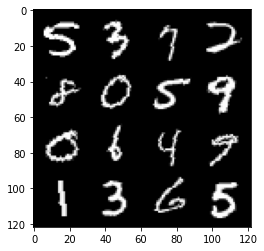

In [ ]:
iterator = iter(train_dataloader)
images, _ = next(iterator)

plot_images(images, num_images=16)

In [ ]:
disc_net = Discriminator().to(device)

summary(disc_net, input_size=(1, 28, 28), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
generator_net = Generator().to(device)

summary(generator_net,input_size=(noise_dim,), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
disc_net = disc_net.apply(weights_init)
generator_net = generator_net.apply(weights_init)

In [ ]:
disc_optimizer = optim.Adam(disc_net.parameters(),
                            lr=learning_rate,
                            betas=(beta_1, beta_2)
                )

generator_optimizer = optim.Adam(generator_net.parameters(),
                            lr=learning_rate,
                            betas=(beta_1, beta_2)
                )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step #20 generator loss: 425.2868569493294, discriminator loss: 285.3424280285835


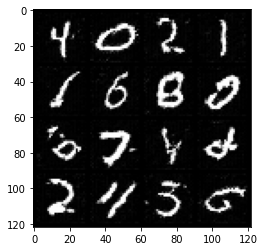

In [ ]:
for i in range(1, epochs+1):
  total_d_loss = .0
  total_g_loss = .0

  for real_images, _ in tqdm(train_dataloader):

    real_images = real_images.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)

    disc_optimizer.zero_grad()

    fake_images = generator_net(noise)
    d_pred = disc_net(fake_images)
    d_fake_loss = fake_loss(d_pred)

    d_pred = disc_net(real_images)
    d_real_loss = real_loss(d_pred)

    d_loss = (d_fake_loss + d_real_loss) / 2
    d_loss.backward()
    disc_optimizer.step()

    generator_optimizer.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device=device)
    fake_images = generator_net(noise)
    d_pred = disc_net(fake_images)

    g_loss = real_loss(d_pred)

    g_loss.backward()
    generator_optimizer.step()

    total_d_loss += d_loss.item()
    total_g_loss += g_loss.item()

  clear_output()
  print(f'Step #{i} generator loss: {total_g_loss}, discriminator loss: {total_d_loss}')
  plot_images(fake_images)